# MLPS - Mercari Price ML

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Perform data cleaning

In [ ]:
data = pd.read_csv("Data/train.tsv", delimiter="\t", index_col=0)

# remove items with out a price
data = data[pd.notna(data["price"])]

data["item_description"] = data["item_description"].replace("No description yet", "")
data["item_description"] = data["item_description"].replace(np.nan, "")

temp = data["category_name"].fillna('').str.split('/')
              
data["category_name_1"] = temp.str[0]
data["category_name_2"] = temp.str[1]
data["category_name_3"] = temp.str[2:].str.join("/")

### Implement porter stemming in count vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.porter import *
import string

class StemmerTokenizer(object):
    def __init__(self):
        self.ps = PorterStemmer()
        self.translator = str.maketrans('', '', string.punctuation + string.digits)
    def __call__(self, doc):
        return [self.ps.stem(w) for w in doc
                .encode('ascii', errors='ignore')
                .decode('ascii')
                .translate(self.translator)
                .split()]

vectorizer = CountVectorizer(lowercase = True,
                             max_df = .5,
                             min_df = .001,
                             tokenizer = StemmerTokenizer(),
                             stop_words='english')

### Count vectorize the data

In [ ]:
%%time
tfm = vectorizer.fit_transform(data["item_description"])

In [ ]:
vocab = vectorizer.vocabulary_ 
removed_words = vectorizer.stop_words_

In [ ]:
%%time
tfidf_vectorizer = TfidfTransformer()
tfidf_transformed = tfidf_vectorizer.fit_transform(tfm)

### Save results for time savings

In [ ]:
from scipy.sparse import save_npz
save_npz("tfm.npz", tfm)
save_npz("tfidf_transformed.npz", tfidf_transformed)

## Vocab: write vectorized words to txt

In [ ]:
import operator
with open("vocabulary.txt", "w") as f:
    f.write("".join([k + '\n' for k, v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]))

<br><br><br><hr><hr>

# Load files as necessary for time savings

In [1]:
import pandas as pd 
import numpy as np
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from scipy.sparse import load_npz

tfm = load_npz("Data/tfm.npz")
tfidf_transformed = load_npz("Data/tfidf_transformed.npz")
categorical = pd.read_csv('Data/train_clean.tsv', sep='\t', header=0)

In [2]:
# take the log of price (0.000000001 added for item with 0 as price)
categorical['log(price)'] = np.log(categorical['price'] + 0.000000001)

# calculate 6 st dev of log(price)
st_dev_log_price_6 = categorical['log(price)'].std()*6

print("pre-filtering ",len(categorical))

# find points that are not outliers
not_outliers = np.array((categorical['log(price)'] < st_dev_log_price_6) & (categorical['log(price)'] > (- st_dev_log_price_6)))

# filter datasets to data only around 6 st dev of log(price)
cleaned_categorical = categorical[not_outliers]
cleaned_categorical.reset_index(drop = True, inplace = True)
tfm = tfm[not_outliers]
tfidf_transformed = tfidf_transformed[not_outliers]

print("post-filtering ",len(cleaned_categorical))

pre-filtering  1482535
post-filtering  1478823


In [3]:
cleaned_categorical.describe()

,train_id,item_condition_id,price,shipping,log(price)
count,1478823.000,1478823.000,1478823.000,1478823.000,1478823.000
mean,741229.160,1.907,25.753,0.447,2.907
std,427967.781,0.903,29.028,0.497,0.776
min,0.000,1.000,3.000,0.000,1.099
25%,370559.500,1.000,10.000,0.000,2.303
50%,741224.000,2.000,17.000,0.000,2.833
75%,1111850.500,3.000,29.000,1.000,3.367
max,1482534.000,5.000,347.000,1.000,5.849


In [4]:

cleaned_categorical["brand_name"][cleaned_categorical["brand_name"].isnull()] = "No Brand Info"

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


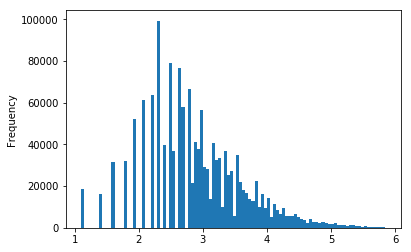

In [5]:
%matplotlib inline
cleaned_categorical['log(price)'].plot.hist(bins= 100)


In [6]:
tfm.shape

(1478823, 1793)

In [7]:
tfidf_transformed.shape

(1478823, 1793)

In [8]:
cleaned_categorical.shape

(1478823, 12)

## Split into train and test

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

y_categorical = cleaned_categorical['price']
cleaned_categorical.drop(["train_id","name","category_name","item_description","price", 'log(price)'], axis=1, inplace=True)
cleaned_categorical["item_condition_id"] = cleaned_categorical["item_condition_id"].astype('str', copy=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
y_categorical.isna().sum()

0

In [11]:
ohe_cleaned_categorical = pd.get_dummies(cleaned_categorical)

In [12]:
#Test Train sample size
import numpy as np
n_sample = 500000
sample = np.random.permutation(y_categorical.shape[0])[:n_sample]

In [13]:
y_categorical_sample = y_categorical[sample]
ohe_cleaned_categorical_sample = ohe_cleaned_categorical.iloc[sample]
tfidf_transformed_sample = tfidf_transformed[sample]

ohe_cleaned_categorical_sample.reset_index(drop = True, inplace = True);
y_categorical_sample.reset_index(drop = True, inplace = True);

y_categorical.isna().sum()

In [14]:
# split into train and test
yTrain, yTest, XTrain, XTest, tfidfTrain, tfidfTest = train_test_split(
    y_categorical_sample, ohe_cleaned_categorical_sample, tfidf_transformed_sample, test_size=0.3, random_state=95)

yTrain.reset_index(drop = True, inplace = True)
yTest.reset_index(drop = True, inplace = True)
XTrain.reset_index(drop = True, inplace = True)
XTest.reset_index(drop = True, inplace = True);


In [15]:
yTrain.isna().sum()

0

In [18]:
# specify number of folds
from sklearn.model_selection import KFold
folds = 2
kf = KFold(n_splits=folds)
kf_inner = KFold(n_splits=folds)

In [19]:
%time
# Test train and validate
alpha_values = [0.01,0.1, 1, 10]
from sklearn.linear_model import Lasso
import copy

mseOuterTrain = []
mseOuterVal = []
mseInnerTrain = []
mseInnerVal = []
mseOverallTrain = []
mseOverallVal= []
mseOutterBeta = []
mseInnerBeta = []


for i, (train_index, val_index) in enumerate(kf.split(yTrain)):
    print(i)
    yTrain_fold = yTrain.iloc[train_index]
    yVal_fold = yTrain.iloc[val_index]

    XTrain_fold = XTrain.iloc[train_index]
    XVal_fold = XTrain.iloc[val_index]
    

    for a_outer in alpha_values:
        print(i, a_outer)
        lasso = Lasso(alpha=a_outer, random_state=111, max_iter=1000).fit(XTrain_fold, yTrain_fold)
        predict_train = lasso.predict(XTrain_fold)
        train_residuals = yTrain_fold - predict_train
        mseOuterTrain.append(copy.deepcopy((i, None, a_outer ,None, np.square(train_residuals).mean())))
        
        predict_val = lasso.predict(XVal_fold)
        val_residuals = yVal_fold - predict_val
        mseOuterVal.append(copy.deepcopy((i, None, a_outer , None, np.square(val_residuals).mean())))
        
        outer_residuals = yTrain - lasso.predict(XTrain)
            
        for j, (train_inner_index, val_inner_index) in enumerate(kf_inner.split(tfidfTrain)):
            tfidfTrain_fold = tfidfTrain[train_inner_index]
            tfidfVal_fold = tfidfTrain[val_inner_index]
            
            outer_residuals_train = outer_residuals[train_inner_index]
            outer_residuals_val = outer_residuals[val_inner_index]
        
            for a_inner in alpha_values:
                print(j, a_outer, a_inner)
                lasso_inner = Lasso(alpha=a_inner, random_state=111, max_iter=1000).fit(tfidfTrain_fold, outer_residuals_train)
                predict_inner_train = lasso_inner.predict(tfidfTrain_fold)
                inner_train_residuals = outer_residuals_train - predict_inner_train
                mseInnerTrain.append(copy.deepcopy((i, j, a_inner, np.square(inner_train_residuals).mean())))

                predict_inner_val = lasso_inner.predict(tfidfVal_fold)
                inner_val_residuals = outer_residuals_val - predict_inner_val
                mseInnerVal.append(copy.deepcopy((i, j, a_inner, np.square(inner_val_residuals).mean())))
            
                residuals_overall_train = yTrain_fold - predict_train + predict_inner_train
                mseOverallTrain.append(copy.deepcopy((i, j, a_outer, a_inner, np.square(residuals_overall_train).mean())))
            
                residuals_overall_val = yVal_fold - predict_val + predict_inner_val
                mseOverallVal.append(copy.deepcopy((i, j, a_outer, a_inner, np.square(residuals_overall_val).mean())))
    

Wall time: 0 ns
0
0 0.01


MemoryError: 

In [21]:
import operator
sorted(mseOverallVal, key = operator.itemgetter(4))

[(1, 1, 0.01, 1, 583.9970991822582),
 (1, 1, 0.01, 10, 583.9970991822582),
 (1, 0, 0.01, 1, 583.9999148325862),
 (1, 0, 0.01, 10, 583.9999148325862),
 (1, 0, 0.01, 0.1, 584.3243163925031),
 (1, 1, 0.01, 0.1, 584.3860221066484),
 (0, 0, 0.01, 1, 591.7003705892129),
 (0, 0, 0.01, 10, 591.7003705892129),
 (0, 1, 0.01, 0.1, 591.7027563822606),
 (0, 1, 0.01, 1, 591.7244033169777),
 (0, 1, 0.01, 10, 591.7244033169777),
 (0, 0, 0.01, 0.1, 593.4391266970739),
 (1, 0, 0.01, 0.01, 601.4152879196058),
 (0, 1, 0.01, 0.01, 611.6036479734761),
 (1, 1, 0.01, 0.01, 647.9176108249728),
 (0, 0, 0.01, 0.01, 658.3323713882111),
 (1, 1, 0.1, 1, 695.1417020820483),
 (1, 1, 0.1, 10, 695.1417020820483),
 (1, 0, 0.1, 1, 695.1417443977508),
 (1, 0, 0.1, 10, 695.1417443977508),
 (1, 0, 0.1, 0.1, 697.2469387310005),
 (0, 0, 0.1, 1, 699.0307385750766),
 (0, 0, 0.1, 10, 699.0307385750766),
 (0, 1, 0.1, 1, 699.0317993699132),
 (0, 1, 0.1, 10, 699.0317993699132),
 (0, 1, 0.1, 0.1, 700.2715211769873),
 (1, 1, 0.1, 0.1

In [22]:
import operator
sorted(mseOuterVal, key = operator.itemgetter(4))

[(1, None, 0.01, None, 583.9970991822582),
 (0, None, 0.01, None, 591.7003705892131),
 (1, None, 0.1, None, 695.1417020820483),
 (0, None, 0.1, None, 699.0307385750766),
 (1, None, 1, None, 791.7518970365624),
 (0, None, 1, None, 801.3171513124418),
 (1, None, 10, None, 812.8920196250185),
 (0, None, 10, None, 822.5909774928707)]

## Lasso: Category (non-text) data

In [ ]:
vocab = pd.read_csv('Data/vocabulary.txt', sep=" ", header=None)

In [ ]:
%%time
from sklearn.linear_model import LassoCV, Lasso

#alpha_values = np.logspace(-4, 2, 6)
alpha_values = [0.001,0.01,0.1]

mseRow = []
mseAll = []
mseOuterTrain = []
mseOuterValidate = []
mseInner = []

#manually grid search over alpha
for alphaOut in alpha_values:
    
    #non-Text data
    lasso = Lasso(alpha=alphaOut, random_state=111, max_iter=1000).fit(XTrain, yTrain)
    yPredOut = lasso.predict(XValid)
    residuals = yValid - yPredOut
    
    mseRow = []
    
    #can't figure out how to implement a validation or test accuracy as the training of the inner model is dependent 
    # on the outermodel's predictions.  If we predict on XValid, then we need to train the inner model on XValid.
    # not sure if this makes sense
    
    #GridSearch manually
    for alphaIn in alpha_values:
        lassoTF = Lasso(alpha=alphaIn, random_state=777, max_iter=1000).fit(tfidfValid, residuals)
        yPredIn = lassoTF.predict(tfidfValid)
        
        #add predictions from non-Text and Text regressions
        yPredFull = yPredOut + yPredIn
        
        #calc mse between full predictions & actuals
        mseRow.append(mean_squared_error(yValid, yPredFull))
    
    #store for of mse's
    mseAll.append(mseRow)
    
mseAll = np.array(mseAll)

In [ ]:
#get bestAlphaOut & In based on the smallest mse from gridsearch
bestAlpha_idx = np.unravel_index(np.argmin(mseAll), mseAll.shape)
#bestAlpha_idx[0]
bestAlphaOut = alpha_values[bestAlpha_idx[0]]
bestAlphaIn = alpha_values[bestAlpha_idx[1]]
print()
print("Best Alpha for Outer Lasso (non-text): {}".format(bestAlphaOut))
print("Best Alpha for Linner Lasso (text): {}".format(bestAlphaIn))

## Run final model with bestAlphas

In [ ]:
lasso = Lasso(alpha=bestAlphaOut, random_state=111).fit(XTrain, yTrain)
yPredOut = lasso.predict(XValid)
residualsBest = yValid - yPredOut

lassoTF = Lasso(alpha=bestAlphaIn, random_state=111).fit(tfidfTrain, residualsBest)
yPredIn = lasso.predict(tfidfValid)

yPredFull = yPredOut + yPredIn

mse_Final = mean_squared_error(yValid, yPredFull)
print("The MSE for the final tuned models is: {}".format(mse_Final))

## Pickle trained models

In [ ]:
from sklearn.externals import joblib
joblib.dump(lasso, 'lasso_cat.pkl')
joblib.dump(lassTF, 'lasso_tfidf.pkl')
#clf = joblib.load('lasso_cat.pkl') 

# Combine non-Text & text data and run Lasso to see if prediction is diff

In [ ]:
#combine non-Text and Text to test it out
# tfDTrain = tfidfTrain.todense()
# comboTrain = pd.concat([XTrain.reset_index(drop = True), pd.DataFrame(tfDTrain)], axis=1)
# comboTrain.shape

In [ ]:
#save lasso on category data as DataFrame, write to csv
# lasso_cat_coef = pd.DataFrame(lasso.coef_, index=XTrain.columns)
# lasso_cat_coef.to_csv("lasso_cat_coef.csv")

# residualsDF = pd.DataFrame(residuals)
# residualsDF.to_csv("residuals.csv")

## Lasso: Text data on residuals

In [ ]:
#save lasso on TFIDF data as DataFrame, write to csv
# lasso_tfidf_coef = pd.DataFrame(lassoTF.coef_, index=vocab.iloc[:,0].values)
# lasso_tfidf_coef.to_csv("lasso_tfidf_coef.csv")

## Lasso: Text data on residuals (per category1)

In [ ]:
#get the category1 column headers
cat1_cols = XTrain.iloc[:,4815:4825].columns

#reset index so can filter using list of indices
residuals.reset_index(drop=True, inplace=True)

In [ ]:
%%time
cat1_coefs = []
tfidfTrain_df = pd.DataFrame(tfidfTrain.todense())  #I think can remove this and uncomment tocsr() line below

for cat1 in cat1_cols:
    #get indices where this category=1
    idx = np.where(XTrain[cat1] == 1)[0]
   
    #filter data with the indices
    X_tf = tfidfTrain_df.iloc[idx,:]   #Don't think need to use this, uncomment next time to deal with sparse
    #X_tf = tfidfTrain.tocsr()[idx,:]  #way to filter sparse matrx with row indices
    y_tf = residuals[idx]
    
    #run Lasso, fit, store coef array
    lassoCat = Lasso(alpha=bestAlphaIn, random_state=10)
    lassoCat.fit(X_tf, y_tf)

    #add this cat1 coefs to a list
    cat1_coefs.append(lassoCat.coef_)

In [ ]:
#covert to DF with cols=vocab and index=category1 names
lasso_allCat1_coef = pd.DataFrame(cat1_coefs, columns=vocab.iloc[:,0].values, index=cat1_cols)
lasso_allCat1_coef.to_csv("lass_allCat1_coef.csv")

<hr><hr><br>

## Recurrent Neural Network

In [ ]:
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation, Reshape
# from keras.layers.recurrent import LSTM, RNN, GRU, SimpleRNN
# from keras.models import load_model
# import keras
# import h5py



In [ ]:
# #default layers = 6, neurons list always should equal 6
# def build_NN(inShape, nnType='RNN'):
    
#     model = Sequential()
#     model.add(Embedding(inShape[1], 64, input_length=maxLen))  #input layer
#     if nnType == 'RNN':
#         model.add(SimpleRNN(32, return_sequences=True))
#         model.add(SimpleRNN(32))
#         model.add(Dense(16, activation='relu'))
#         model.add(Dense(8, activation='relu'))
#     elif nnType == 'GRU':
#         #model.add(Dense(64, input_shape=(inShape[1])))  #input layer
#         model.add(GRU(32, return_sequences=True))
#         model.add(GRU(32))
#         model.add(Dense(16, activation='relu'))
#         model.add(Dense(8, activation='relu'))
#     elif nnType == 'LSTM':
#         #model.add(Dense(64, input_shape=(inShape[1])))  #input layer
#         model.add(LSTM(32, return_sequences=True)) 
#         model.add(LSTM(32))
#         model.add(Dense(16, activation='relu'))      
#         model.add(Dense(8, activation='relu'))
#     elif nnType == 'BASE':
#         #model.add(Dense(64, input_shape=(inShape[1],)))  #input layer
#         model.add(Dense(32, activation='relu'))
#         model.add(Dense(32, activation='relu'))
#         model.add(Dense(16, activation='relu'))
#         model.add(Reshape((-1,)))
#         model.add(Dense(8, activation='relu'))
#     else:
#         print('should not be here')
    
#     model.add(Dense(1, activation='linear', kernel_initializer="uniform")) #output layer
#     model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#     #model.summary() 

#     return model

In [ ]:
# #params for NN
# epochs = 10
# batchSize = 3000

# #Need to prep the data for the NN

# X = tokenizer.texts_to_sequences(train5k)
# data = pad_sequences(sequences, maxlen=max_len)


# modelRNN = build_NN(tfidf_train.shape, nnType='RNN')
# modelRNN.summary()